# 8-7. 프로젝트: 한영 번역기 만들기

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import time
import re
import os
import io

from konlpy.tag import Mecab
from tqdm import tqdm    # tqdm
import random

## Step 1. 데이터 준비

In [2]:
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/train.ko'

with open(path_to_file, "r") as f:
    train_ko_raw = f.read().splitlines()

print("Data Size:", len(train_ko_raw))

print("Example:")
for sen in train_ko_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [3]:
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/train.en'

with open(path_to_file, "r") as f:
    train_en_raw = f.read().splitlines()

print("Data Size:", len(train_en_raw))

print("Example:")
for sen in train_en_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [4]:
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/test.ko'

with open(path_to_file, "r") as f:
    test_ko_raw = f.read().splitlines()

print("Data Size:", len(test_ko_raw))

print("Example:")
for sen in test_ko_raw[0:100][::20]: print(">>", sen)

Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 수입하는 나라이며, 전적으로 원유 수입에 의존하고 있다.
>> 불과 1,379년 전이다.
>> 대신, 그들은 "안정"이라는 면에서 서방 세계와 똑같은 이해 관계를 갖고 있는 각 지역의 소수 엘리트를 대표하고 있다.


In [5]:
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/test.en'

with open(path_to_file, "r") as f:
    test_en_raw = f.read().splitlines()

print("Data Size:", len(test_en_raw))

print("Example:")
for sen in test_en_raw[0:100][::20]: print(">>", sen)

Data Size: 2000
Example:
>> Those involved in the discussions do take seriously the need to address concerns of law enforcement and national security.
>> Even though the threat is small, the potential effects are devastating.
>> South Korea is the world's fourth largest oil importer and wholly depends on imports of crude.
>> That is only 1,379 years ago.
>> Instead, they represent a small elite in each place that has a common interest with the West in “stability.”


In [6]:
ko_raw = train_ko_raw + test_ko_raw
len(ko_raw)

96123

In [7]:
en_raw = train_en_raw + test_en_raw
len(en_raw)

96123

## Step 2. 데이터 정제

In [8]:
cleaned_corpus = set(list(zip(ko_raw, en_raw)))

In [9]:
def preprocess_sentence_ko(sentence, s_token=False, e_token=False):
    mecab = Mecab()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = mecab.morphs(sentence) #mecab으로 토큰화
    
    return sentence

In [10]:
def preprocess_sentence_en(sentence, s_token=True, e_token=True):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = sentence.split() #split()함수로 토큰화
    
    return sentence

In [11]:
def preprocessing(cleaned_corpus):
    kor_corpus = []
    eng_corpus = []
    for sentence in cleaned_corpus:
        sentence_ko = preprocess_sentence_ko(sentence[0])
        sentence_en = preprocess_sentence_en(sentence[1])
        if len(sentence_ko) <= 20 and len(sentence_en) <= 20: #길이 40이하만 포함
            kor_corpus.append(sentence_ko)
            eng_corpus.append(sentence_en)
    
    return kor_corpus, eng_corpus

In [12]:
kor_corpus, eng_corpus = preprocessing(cleaned_corpus)

In [13]:
print(ko_raw[100])
print(en_raw[100])
print(len(kor_corpus))
print(kor_corpus[100])
print(len(eng_corpus))
print(eng_corpus[100])

제 23차 연례 컴덱스 박람회의 개회사를 한 케이츠는 2년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다.
Gates, who opened the 23rd annual Comdex trade show, said there was a negative perception of high tech following the collapse of the tech bubble about two years ago.
15877
['영어사전']
15877
['<start>', 'a', 'police', 'officer', 'also', 'died', 'in', 'one', 'of', 'the', 'blasts', '.', '<end>']


## Step 3. 데이터 토큰화

In [14]:
from keras.preprocessing.text import Tokenizer

def tokenize(corpus):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

num_words = default

Korean Vocab Size: 41013
English Vocab Size: 43058

In [15]:
# 토큰화하기
# 훈련 데이터와 검증 데이터로 분리하기

enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 15941
English Vocab Size: 15713


## Step 4. 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아질 거랍니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [21]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 15714)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [23]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src) #Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
        h_dec = enc_out[:, -1] #enc_out에서 <end> 제거?? t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의.
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1) #Decoder에 입력으로 전달할 <start> 토큰 문장 생성

        for t in range(1, tgt.shape[1]): #아래 과정 반복
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred) #예측된 단어와 정답간의 로스를 구함
            dec_src = tf.expand_dims(tgt[:, t], 1) # t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [24]:
# eval_step() 정의하기
@tf.function

def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss
# train_step() 이후 eval_step() 진행하도록 소스 수정하기




## Step 5. 훈련하기

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 본인이 생각하기에 가장 멋지게 번역한 Case를 제출하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

In [25]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence_ko(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [26]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [27]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

In [28]:
def translate2(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)
    print('Predicted translation: {}'.format(result))

In [29]:
example = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

In [30]:
EPOCHS = 30

loss_history = []
test_loss_history = []

for epoch in range(EPOCHS):
    total_loss = 0


    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    total_loss_history = []
    

    test_loss = 0

    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)

        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))
    for sentence in example:
        translate2(sentence, encoder, decoder)
    loss_history.append(total_loss.numpy() / (batch + 1))
    test_loss_history.append(test_loss.numpy() / (test_batch + 1))

Test Epoch  1: 100%|██████████| 50/50 [00:09<00:00,  5.19it/s, Test Loss 4.1148]


Predicted translation: the the the the the the the the the the the the the the the the the the the the 
Predicted translation: the the the the the the the the the the the the the the the the the the the the 
Predicted translation: the the the the the the the the the the the the the the the the the the the the 


Epoch  2:   1%|          | 1/199 [00:00<00:36,  5.42it/s, Loss 4.0859]

Predicted translation: the the the the the the the the the the the the the the the the the the the the 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: the first . <end> 
Predicted translation: the first . <end> 
Predicted translation: the first year . <end> 
Predicted translation: the first . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: the world s . <end> 
Predicted translation: the world s . <end> 
Predicted translation: the world s . <end> 
Predicted translation: the world . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: the first time . <end> 
Predicted translation: the first time to the world . <end> 
Predicted translation: the first time . <end> 
Predicted translation: the first round of the first round of the first round of the first round of the first round of 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: the ap s lawyer , the us . <end> 
Predicted translation: the united nations and the united nations and the united nations and the united nations and the united nations and 
Predicted translation: the united nations . <end> 
Predicted translation: the attack . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: the government , the government , the government , the government , the government , the government , the government 
Predicted translation: the u . s . <end> 
Predicted translation: the company says the economy . <end> 
Predicted translation: the hospital and the hospital and the hospital and the hospital and the hospital and the hospital and the hospital 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: the president elect barack obama said . <end> 
Predicted translation: the group . <end> 
Predicted translation: it s a lot of the boss , but it s a lot of the boss , but it s 
Predicted translation: the hospital . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama said he s lawyer , obama said he s lawyer , obama said he s lawyer , obama said 
Predicted translation: the dalai lama has been squeezed out of the region . <end> 
Predicted translation: and unyielding hope <end> 
Predicted translation: the hospital . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama also won . <end> 
Predicted translation: they are also been lodged a foot . <end> 
Predicted translation: we ve got a rigorous investigation . <end> 
Predicted translation: the hospital , the hospital , the hospital , the hospital , the hospital , the hospital , the hospital 


Test Epoch 10: 100%|██████████| 50/50 [00:02<00:00, 19.49it/s, Test Loss 4.1658]


Predicted translation: obama said he s no battleground states . <end> 
Predicted translation: doctors are accused thaksin was discovered by cowards . <end> 
Predicted translation: but it s a lot of course that hanalei is a lot of course that hanalei is a lot of 


Epoch 11:   1%|          | 1/199 [00:00<00:39,  5.06it/s, Loss 1.2772]

Predicted translation: another were injured , were taken to hospitals , the blaze , the blaze , the blaze , the blaze 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama s ceo rick wagoner . <end> 
Predicted translation: people in the region . <end> 
Predicted translation: i m a lot of excess of the referee no doubt . <end> 
Predicted translation: the blaze , the sources said . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama also too far fetched . <end> 
Predicted translation: they say many people in moscow . <end> 
Predicted translation: they can be difficult for a list <end> 
Predicted translation: two of the hospital , the cyclone . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama said . <end> 
Predicted translation: people damaged skin . <end> 
Predicted translation: i m a lot of coffee <end> 
Predicted translation: the police , the police , the police , the police , the police , the police , the police 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama s camp touted a key battleground states . <end> 
Predicted translation: people have been related to arm themselves . <end> 
Predicted translation: some kind of coffee has changed that kind of coffee has changed that kind of coffee has changed that kind 
Predicted translation: three were injured , police said . <end> 


Test Epoch 15: 100%|██████████| 50/50 [00:02<00:00, 19.46it/s, Test Loss 4.7478]


Predicted translation: obama also too far fetched . <end> 
Predicted translation: they are required to arm themselves . <end> 
Predicted translation: they have a lot of coffee has had a nebula is the referee no more difficult . <end> 


Epoch 16:   1%|          | 1/199 [00:00<00:36,  5.39it/s, Loss 0.4436]

Predicted translation: two of the seven astronauts were injured , who were killed , who were killed , who were killed , 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama also too on the campaign . <end> 
Predicted translation: passengers must submit related to protect their lives and property . <end> 
Predicted translation: i m that includes that kind of coffee has even newer software changes . <end> 
Predicted translation: two girls . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama says he s camp touted a cnn tally . <end> 
Predicted translation: they are also moved to arm themselves to urban areas . <end> 
Predicted translation: there s a lot of coffee has even newer software changes . <end> 
Predicted translation: two of the seven astronauts were reported . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama also made on obama s camp touted a candidate will depend in his campaign . <end> 
Predicted translation: people in pakistan . <end> 
Predicted translation: the airplane <end> 
Predicted translation: eighteen of the victims of the victims of the victims of the victims of the victims of the victims of 


Test Epoch 19: 100%|██████████| 50/50 [00:02<00:00, 19.40it/s, Test Loss 5.1451]


Predicted translation: obama says he was charged with plotting to head the boisterous crowed <end> 
Predicted translation: parts of vandalism high water . <end> 
Predicted translation: like the tunnel moo hyun has had the tunnel moo hyun has had the tunnel moo hyun has had the 


Epoch 20:   1%|          | 1/199 [00:00<00:37,  5.34it/s, Loss 0.3773]

Predicted translation: he was taken , but the sources of the seven astronauts were seriously , but the sources of the seven 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama also warned his current post s camp touted a candidate to the same time to the oval office <end> 
Predicted translation: people are beginning to protect their lives and property . <end> 
Predicted translation: i m that kind of different chemical compounds . <end> 
Predicted translation: two of the seven astronauts were seriously . <end> 


Test Epoch 21: 100%|██████████| 50/50 [00:02<00:00, 19.15it/s, Test Loss 5.3398]


Predicted translation: obama says he s making the obama election <end> 
Predicted translation: they are threatened to arm themselves to protect their lives and property . <end> 
Predicted translation: the truth is a coffee has changed that kind of coffee has changed that kind of coffee has changed that 


Epoch 22:   1%|          | 1/199 [00:00<00:35,  5.54it/s, Loss 0.1976]

Predicted translation: five girls , and the suspect , and the suspect , and the suspect , and the suspect , and 


Test Epoch 22: 100%|██████████| 50/50 [00:02<00:00, 19.47it/s, Test Loss 5.4110]


Predicted translation: obama says he s making the chief economist on the obama election . <end> 
Predicted translation: people are to arm themselves to protect their lives and property . <end> 
Predicted translation: i m that kind of coffee has changed the truth of course has ever heard of coffee has changed the 


Epoch 23:   1%|          | 1/199 [00:00<00:35,  5.53it/s, Loss 0.1463]

Predicted translation: the four man , and the seven astronauts were injured , but as far , but survived by the seven 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama says he s camp touted a point of obama election <end> 
Predicted translation: parts of vandalism high to arm themselves to arm themselves to arm themselves to arm themselves to arm themselves to 
Predicted translation: how can be difficult for coffee has has ever heard of coffee has has ever heard of coffee has has 
Predicted translation: five were seriously hurt . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama says he s making the obama election <end> 
Predicted translation: people are threatened to protect their daily , south asian , south asian , south asian , south asian , 
Predicted translation: it s a few men isn t what the truth of course of coffee has changed that kind of coffee 
Predicted translation: two had children . <end> 


Test Epoch 25: 100%|██████████| 50/50 [00:02<00:00, 19.40it/s, Test Loss 5.6678]


Predicted translation: obama says he was elected to the bill that obama says he was elected to the bill that obama says 
Predicted translation: people are to arm themselves to urban . <end> 
Predicted translation: some of coffee has changed that kind of coffee has changed that kind of coffee has changed that kind of 


Epoch 26:   1%|          | 1/199 [00:00<00:38,  5.17it/s, Loss 0.1212]

Predicted translation: he was taken , and the seven astronauts were injured , and the seven astronauts were injured , and the 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama says he was worse than clinton , obama says he was worse than clinton , obama says he was 
Predicted translation: parts of people to arm themselves to protect their lives and property . <end> 
Predicted translation: which kind of coffee has changed that kind of coffee has changed that kind of coffee has changed that kind 
Predicted translation: two girls . <end> 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama says he s camp touted a point of the obama election draws the boisterous crowed <end> 
Predicted translation: parts of people to arm themselves to protect their lives and property . <end> 
Predicted translation: we need is a living laboratory and her doctors says of different chemical compounds . <end> 
Predicted translation: five are , , and had children . <end> 


Test Epoch 28: 100%|██████████| 50/50 [00:02<00:00, 19.42it/s, Test Loss 5.8774]


Predicted translation: obama says he was worse than clinton , he says he was worse than clinton , he says he was 
Predicted translation: parts of vandalism credit to arm themselves to protect their lives and less than million . <end> 
Predicted translation: the truth of course that kind of coffee has changed the coffee has changed the coffee has changed the coffee 


Epoch 29:   1%|          | 1/199 [00:00<00:37,  5.26it/s, Loss 0.0943]

Predicted translation: the victims were taken to be the seven astronauts were taken to be the seven astronauts were taken to be 


  0%|          | 0/199 [00:00<?, ?it/s]

Predicted translation: obama says he was . <end> 
Predicted translation: people are to arm themselves to protect their lives and property . <end> 
Predicted translation: what the truth of different chemical compounds . <end> 
Predicted translation: the four , but survived and were seriously , but five people were seriously , but five people were seriously 


Test Epoch 30: 100%|██████████| 50/50 [00:02<00:00, 19.43it/s, Test Loss 5.9917]


Predicted translation: obama says he s ceo rick wagoner . <end> 
Predicted translation: people are to arm themselves to protect their lives and property . <end> 
Predicted translation: some clinics were the coffee has hundreds of coffee has hundreds of coffee has hundreds of coffee has hundreds of 
Predicted translation: five were seriously seriously . <end> 


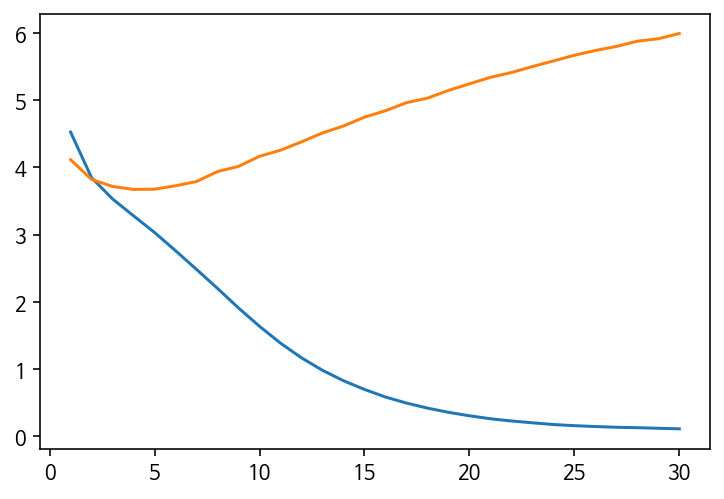

In [31]:
history = []
for i in range(0, len(loss_history)):
    history.append(i+1)

plt.figure()
plt.plot(history, loss_history)
plt.plot(history, test_loss_history)
plt.show()

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama says he s ceo rick wagoner . <end> 


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


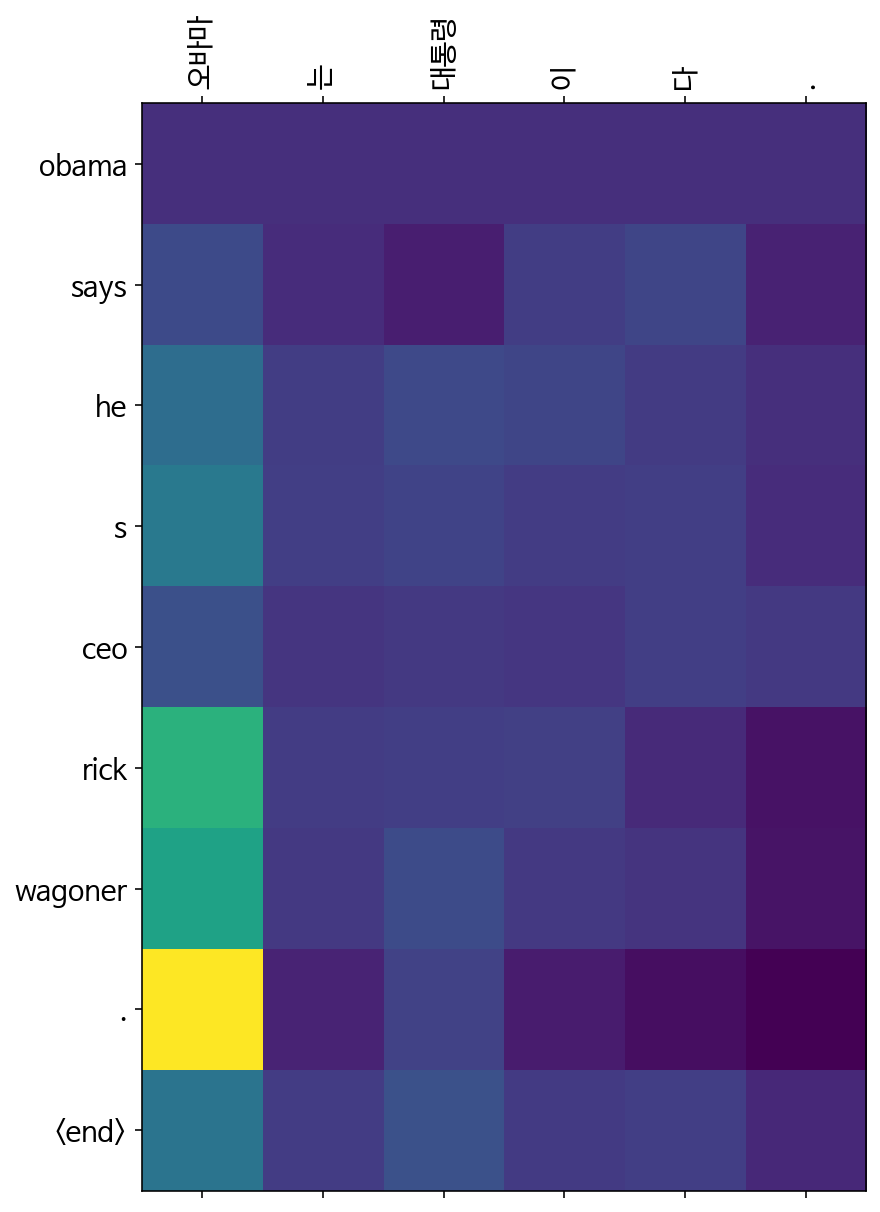

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: people are to arm themselves to protect their lives and property . <end> 


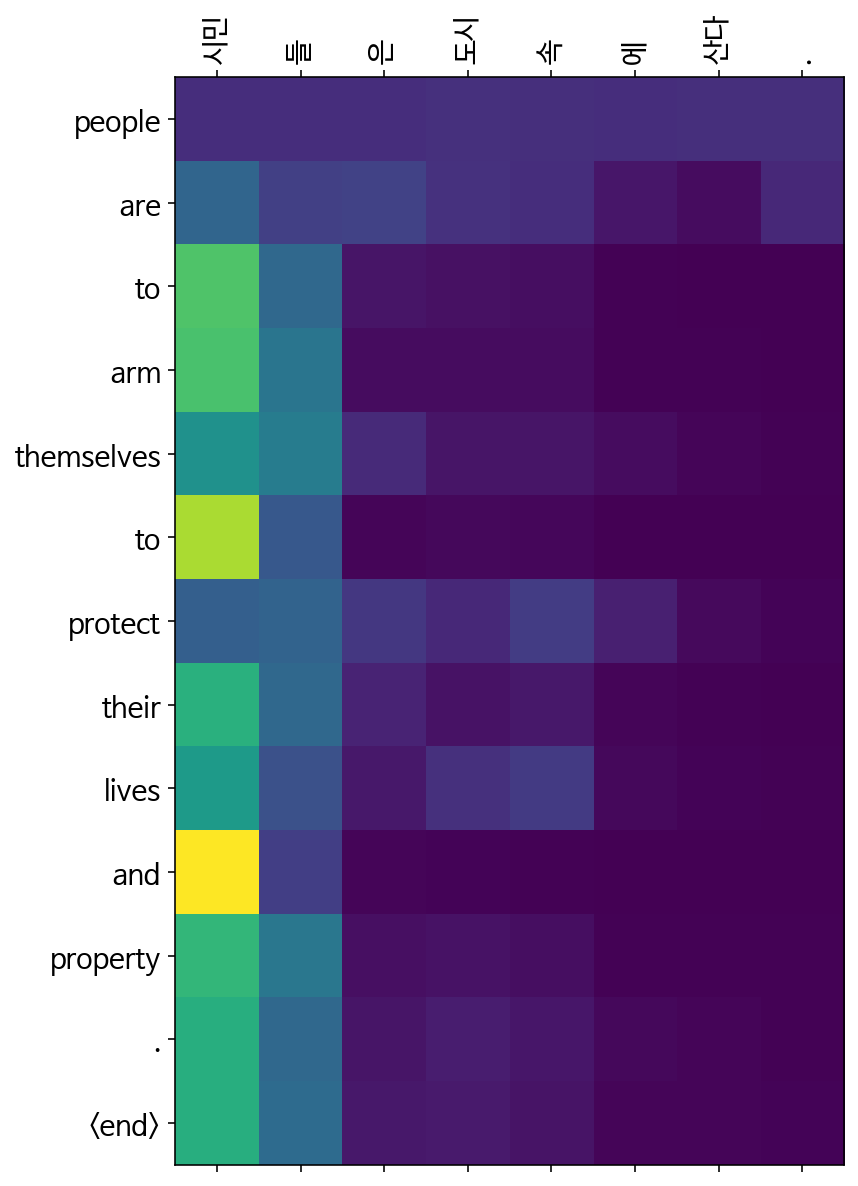

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: some clinics were the coffee has hundreds of coffee has hundreds of coffee has hundreds of coffee has hundreds of 


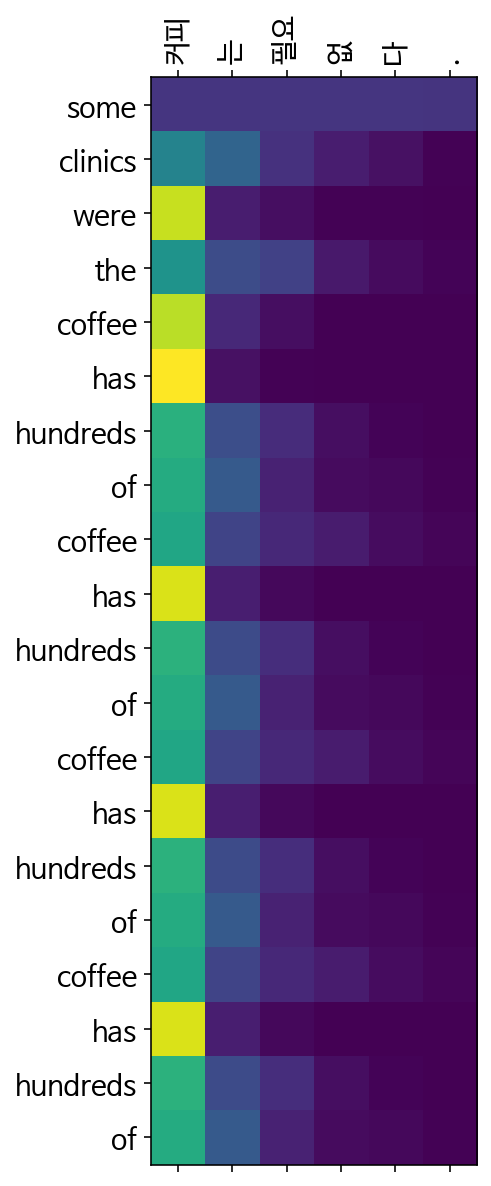

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: five were seriously seriously . <end> 


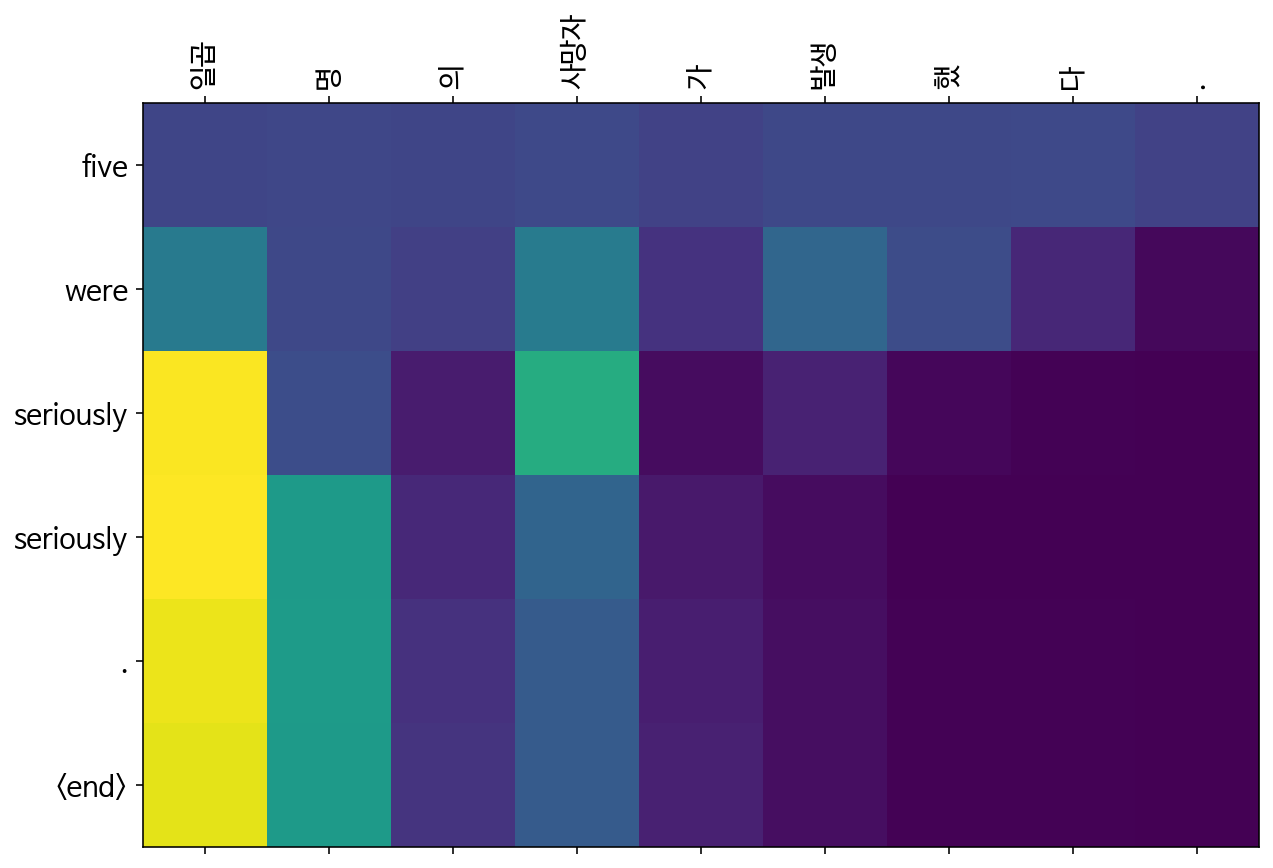

In [33]:
for i in example:
    translate(i, encoder, decoder)

Input: ['장난', '해', '?']
Predicted translation: and old , at , for two , for two , for two , for two , for two , 


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


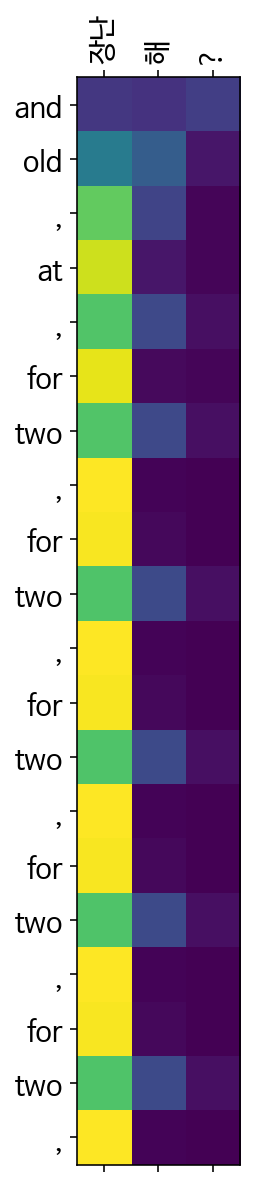

In [34]:
translate("장난해?", encoder, decoder)

## 결과 분석

len(words) = 20, epoch 20/30

Predicted translation: obama has already the boisterous crowed <end> 
Predicted translation: the case is an internet is in , there is in , there is in , there is in , 
Predicted translation: the kids are also laying out of different chemical . <end> 
Predicted translation: the dead were abducted caused by the fire . <end> 
    
오바마라는 고유명사는 epoch 5에 처음 등장하여 계속하여 고정적으로 번역되었다.
일곱의 경우 epoch 15부터 three, forth등 숫자가 연관되어 등장했지만 실제로는 . 부근에서 가장 활성화 되었다.
또한 loss 그래프에선 epoch 6이후 loss의 발산이 확인되었다.
    
file:///home/aiffel0042/aiffel/songys_chatbot/20-%2030epoch.png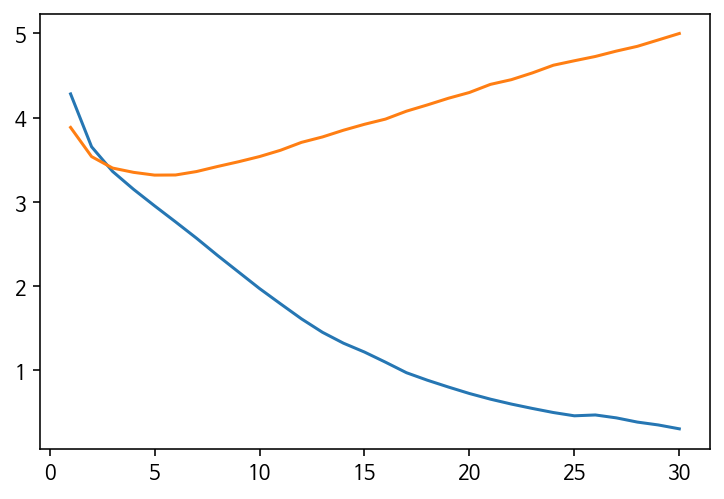

len(words) = 25, epoch 17/30

Predicted translation: obama says he s camp touted a cnn tally . <end> 
Predicted translation: they are also moved to arm themselves to urban areas . <end> 
Predicted translation: there s a lot of coffee has even newer software changes . <end> 
Predicted translation: two of the seven astronauts were reported . <end> 
    
epoch 7에서 오바마와 대통령 두가지 키워드를 잡아냈으나 이후 등장하지 않았다. 이는 오버피팅의 영향으로 추측된다.
토큰 최대 수를 25로 늘리니 비교적 키워드 커피, 일곱 등을 잘 잡아내는 모습이 보였다.
그러나 여전히 그래프는 발산한다.

file:///home/aiffel0042/aiffel/songys_chatbot/25-%2030epoch.png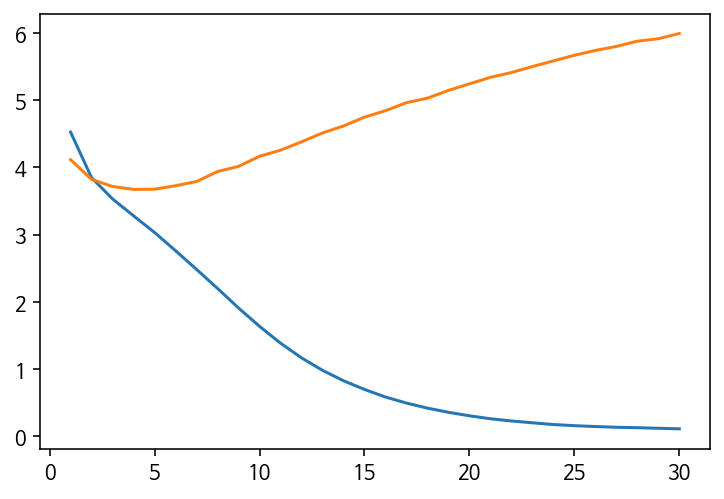

len(words) = 30, epoch 30
그래프는 수렴했으나 translate함수가 정상적으로 작동하지 못하였다. 로스 감소와 무관하게 충분한 학습이 이루어지지 못한 것으로 보인다.
혹은 학습 방법의 개선이 필요하다.

file:///home/aiffel0042/aiffel/songys_chatbot/30-30epoch.png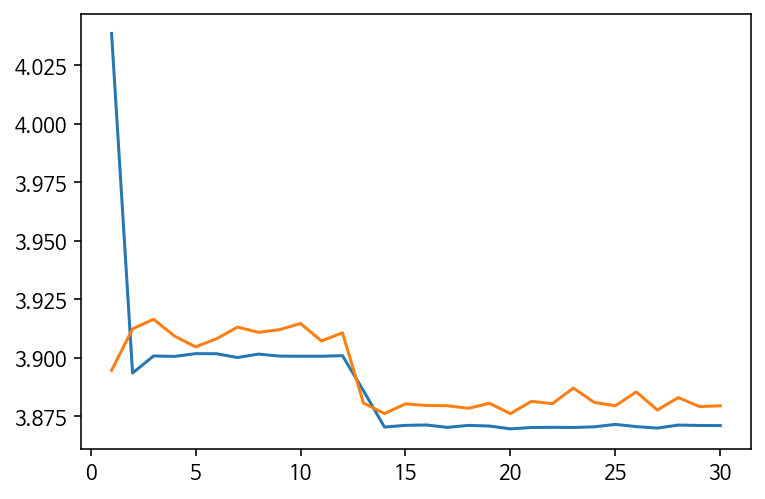